In [1]:
import numpy as np
import cv2 as cv
import  matplotlib.pyplot as plt
import re

In [2]:
img1 = cv.imread('data/FurukawaPonce/MorpheusL.jpg') #queryimage # left image
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.imread('data/FurukawaPonce/MorpheusR.jpg') #trainimage # right image
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

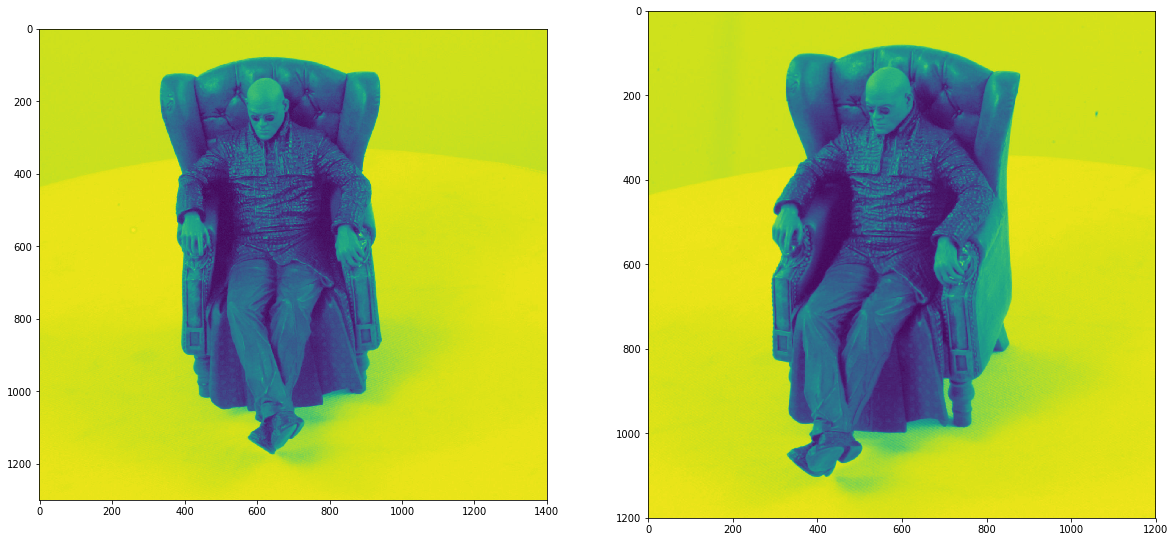

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()

## fix images size

In [4]:
img1.shape, img2.shape

((1300, 1400), (1200, 1200))

In [5]:
#img2 = cv.copyMakeBorder(img2,0,100,200,0,cv.BORDER_CONSTANT)
dim = (1400, 1300)
img2 = cv.resize(img2, dim, interpolation = cv.INTER_AREA)

img1.shape, img2.shape

((1300, 1400), (1300, 1400))

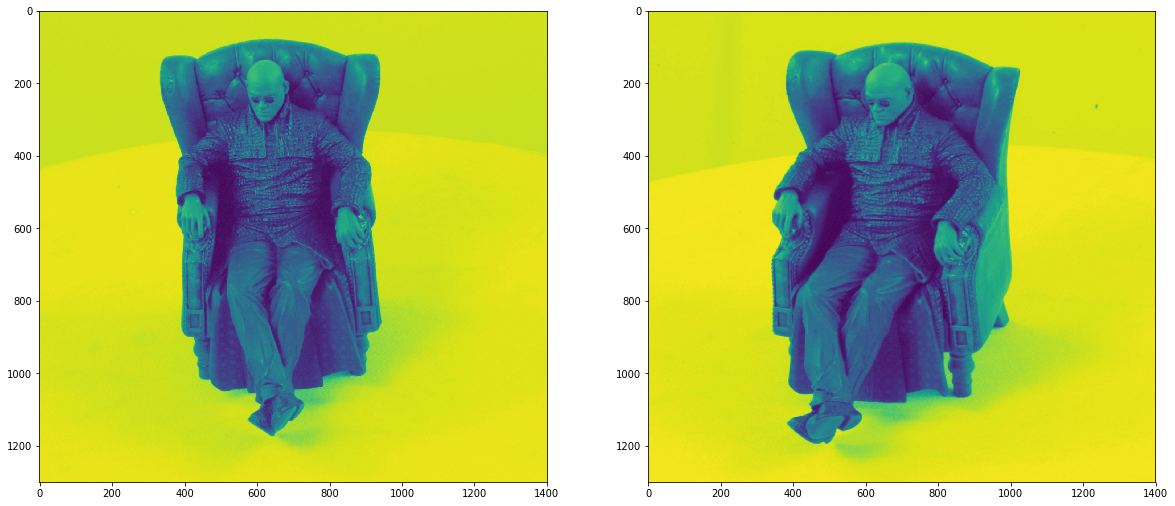

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()

## load cams parameters

In [7]:
def load_calib_dict(file_path):
    """ """
    d = {}
    data = ''
    with open(file_path) as f:
        data = f.readlines()
        for idx in range(len(data)):
            data[idx] = data[idx].replace("\n","")
            
        d['fc'] = eval(data[1].split('=')[1].replace(";",","))
        d['cc'] = eval(data[4].split('=')[1].replace(";",","))
        d['alpha_c'] = float(data[6].split('=')[1].replace(";",""))
        
        r0 = eval(data[11].split("=")[1].replace(";","]"))
        r1 = eval(data[12].replace("      ","[").replace(";","]"))
        r2 = eval(data[13].replace("     ","["))
        d['R'] = np.array([r0, r1, r2])
        
        d['Tc'] = eval(data[15].split("=")[1].replace(";",','))
    return d

calib_dict_left = load_calib_dict("data/FurukawaPonce/MorpheusL.txt")
calib_dict_right = load_calib_dict("data/FurukawaPonce/MorpheusR.txt")

calib_dict_left

{'fc': [6704.926882, 6705.241311],
 'cc': [738.251932, 457.560286],
 'alpha_c': 0.000103,
 'R': array([[ 0.70717199,  0.70613396, -0.03581348],
        [ 0.28815232, -0.33409066, -0.89741388],
        [-0.64565936,  0.62430623, -0.43973369]]),
 'Tc': [-532.2859, 207.1836, 2977.408]}

## Computes fundamental matrix

In [8]:
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
len(pts1),len(pts2)

(296, 296)

In [9]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [10]:

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

F

array([[ 5.77502507e-07,  4.66613283e-06, -3.75793914e-03],
       [-5.24208194e-06,  8.87047918e-07,  1.34894022e-02],
       [ 2.20924942e-03, -1.43917018e-02,  1.00000000e+00]])

In [11]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
len(pts1),len(pts2)

(207, 207)

## Computes essential matrix

In [12]:
## Builds K matrix 

K_left = [[calib_dict_left['fc'][0],0,calib_dict_left['cc'][0]],
         [0, calib_dict_left['fc'][1], calib_dict_left['cc'][1]],
         [0, 0, 1]]
K_left = np.array(K_left)

K_right = [[calib_dict_right['fc'][0],0,calib_dict_right['cc'][0]],
         [0, calib_dict_right['fc'][1], calib_dict_right['cc'][1]],
         [0, 0, 1]]
K_right = np.array(K_right)

In [13]:
E = K_right.T * F * K_left
E

array([[25.87394068,  0.        , -0.        ],
       [-0.        , 39.74055273,  0.        ],
       [ 0.        , -0.        ,  1.        ]])

## Recovers Pose relative to the cameras

In [14]:
retval, R, t, mask = cv.recoverPose(E,pts1,pts2)
print(retval)

60


In [15]:
R

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [16]:
t

array([[ 0.],
       [ 0.],
       [-1.]])

In [17]:
## Usa stereoCalibrate() para recuperar os parametros conjuntos das cameras

## Usa stereoRectify() para retificar as imagens

In [18]:
rectify_scale= 1
#dist_coeffs = np.array([0,0,0,0,0])
dist_coeffs1 = np.array([-0.125368, -0.097388, -0.003711, -0.000161, 0.000000])
dist_coeffs2 = np.array([-0.106090, -0.533543, -0.005174, 0.000517, 0.000000])

rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiL, roiR = cv.stereoRectify(
    cameraMatrix1=K_left,
    distCoeffs1=dist_coeffs1, 
    cameraMatrix2=K_right, 
    distCoeffs2=dist_coeffs2, 
    imageSize=img1.shape[::-1], 
    R=R, 
    T=t)

In [19]:
proj_mat_l

array([[ 6.69352642e+03,  0.00000000e+00, -6.52502761e+03,
         0.00000000e+00],
       [ 0.00000000e+00,  6.69352642e+03,  1.43609383e+05,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00]])

In [20]:
rect_l

array([[ 7.07106781e-01, -7.07106781e-01,  0.00000000e+00],
       [ 4.32978028e-17,  4.32978028e-17,  1.00000000e+00],
       [-7.07106781e-01, -7.07106781e-01,  6.12323400e-17]])

In [21]:
Left_Stereo_Map = cv.initUndistortRectifyMap(K_left, dist_coeffs1, rect_l, proj_mat_l,
                                             img1.shape[::-1], cv.CV_16SC2)

Right_Stereo_Map= cv.initUndistortRectifyMap(K_right, dist_coeffs2, rect_r, proj_mat_r,
                                              img1.shape[::-1], cv.CV_16SC2)

In [22]:
Left_nice= cv.remap(img1,Left_Stereo_Map[0],Left_Stereo_Map[1], cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)

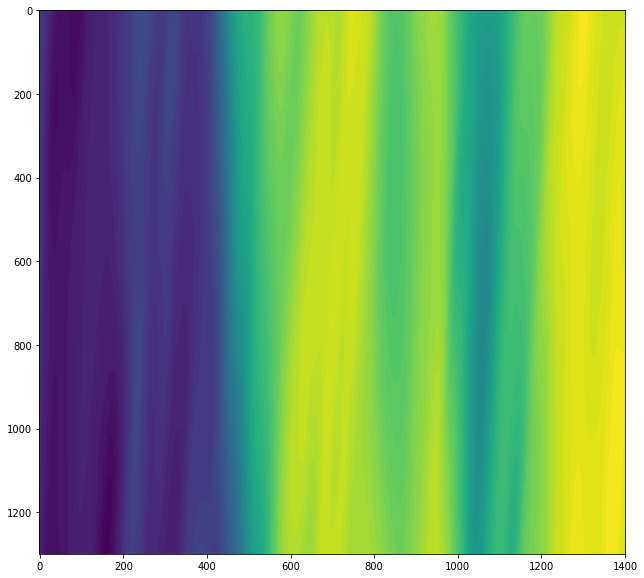

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.imshow(Left_nice)
plt.show()

## FAIL

### Try it using homografy

In [24]:
H, mask = cv.findHomography(pts1, pts2)

In [25]:
H

array([[ 9.82274098e-01, -2.04701243e-01,  9.09617924e+01],
       [ 9.23066869e-02,  9.59904530e-01, -4.20444546e+01],
       [-3.20189090e-05, -2.93588715e-05,  1.00000000e+00]])

In [26]:
img1_warp = cv.warpPerspective(img1, H, (img1.shape[1], img1.shape[0]))
img2_warp = cv.warpPerspective(img2, H, (img2.shape[1], img2.shape[0]))

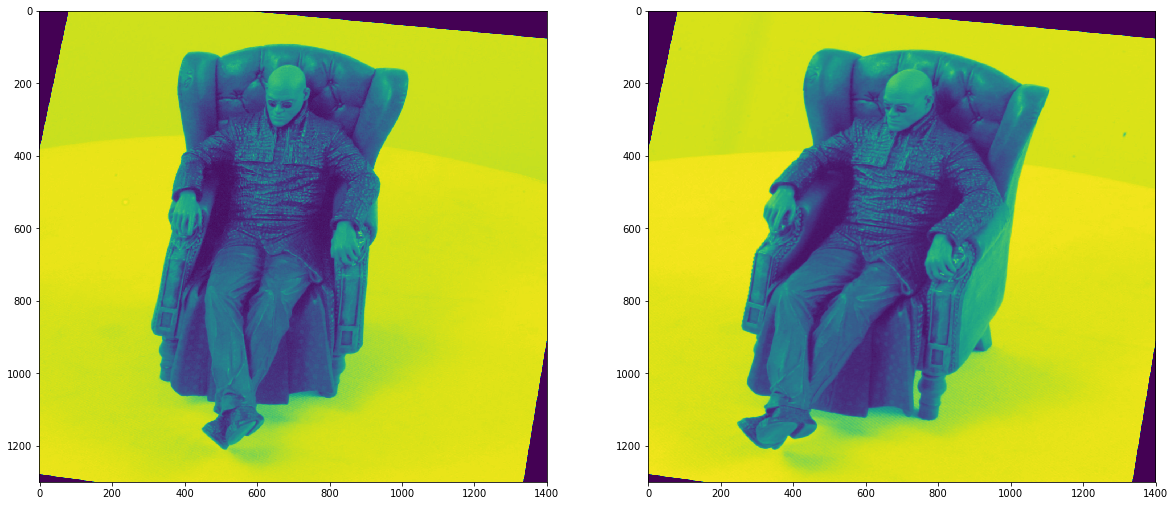

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(img1_warp)
plt.subplot(122),plt.imshow(img2_warp)
plt.show()

In [28]:
cv.imwrite('morpheus_L_rectified.png', img1_warp)

True

In [29]:
cv.imwrite('morpheus_R_rectified.png', img2_warp)

True

### Rematches points after rectification

In [30]:
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1_warp,None)
kp2, des2 = sift.detectAndCompute(img2_warp,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
len(pts1),len(pts2)

(267, 267)

In [31]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [32]:
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

In [33]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
len(pts1),len(pts2)

(190, 190)

In [34]:
img_draw_matches = cv.hconcat([img1_warp, img2_warp])
for i in range(len(pts1)):
    pt1 = np.array([pts1[i][0], pts1[i][1], 1])
    pt1 = pt1.reshape(3, 1)
    pt2 = np.dot(H, pt1)
    pt2 = pt2/pt2[2]
    end = (int(img1.shape[1] + pt2[0]), int(pt2[1]))
    cv.line(img_draw_matches, tuple([int(j) for j in pts1[i]]), end, 5, 2)


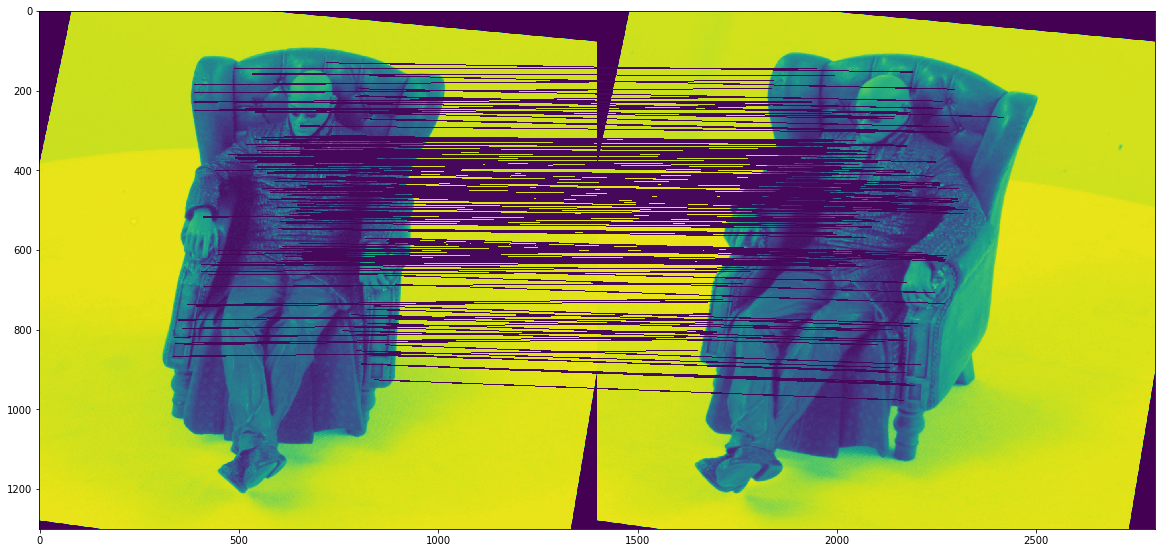

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.imshow(img_draw_matches)
plt.show()

In [36]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

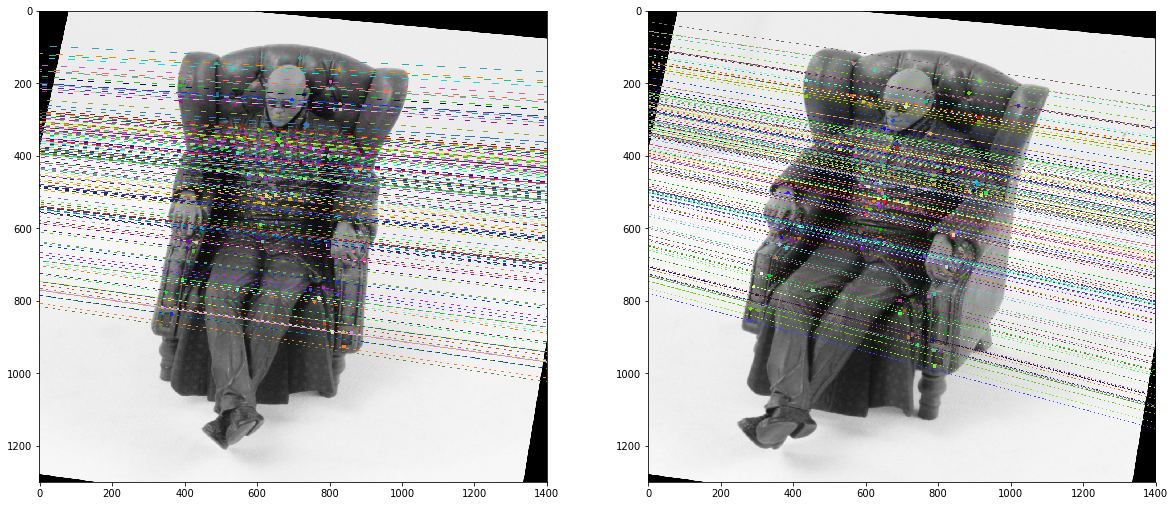

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1_warp,img2_warp,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2_warp,img1_warp,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()